In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pandas as pd
import matplotlib.pylab as plt

plt.rcParams['lines.linewidth'] = 3

In [136]:
def calc_height(t, p, jump = True):
    '''
    isotherm height formular
    z = -R*t0/g * ln(p/p0)
    z = -287.053*t0/9.80665 * ln(p/p0)
    
    polytrop height forumular
    z = t0/L * ((p/p0)**(-L*R/g) -1)
    L = −0.0065 K/m
    R = 287.053 J/(kg K)
    g = 9.80665 m/s2
    z = t0/−0.0065 * ((p/p0)**(0.0065*287.053/9.80665) -1)
    
    international height formular
    z = 288.15/0.0065 * (1- (p/1013.25)**(1/5.255))
    
    '''
    # from: https://www.cesm.ucar.edu/models/cesm1.1/cesm/cesmBbrowser/html_code/cam/tropopause.F90.html
    SHR_CONST_AVOGAD  = 6.02214e26
    SHR_CONST_BOLTZ   = 1.38065e-23
    SHR_CONST_MWDAIR  = 28.966
    SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
    SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR
    rair = SHR_CONST_RDAIR

    SHR_CONST_G       = 9.80616
    gravit = SHR_CONST_G

    SHR_CONST_CPDAIR  = 1.00464e3
    cappa        = (SHR_CONST_RGAS/SHR_CONST_MWDAIR)/SHR_CONST_CPDAIR
    cnst_kap = cappa

    cnst_faktor = -gravit/rair
    cnst_ka1    = cnst_kap - 1.
        
    z = []
    for i in range(len(t)):
        
        if i == 0:
            L = -0.0065
            height = t[i]/L * ((p[i]/101325)**(-L*287.053/9.80665) -1)
            z.append(height)
        else:
            if jump:
                if z[i-1] < 11000:
                    L = -0.0065
                else:
                    L = -0.001
            else:                    
                # dt/dz
                pmk= .5 * (p[i-1]**cnst_kap+p[i]**cnst_kap)
                pm = pmk**(1/cnst_kap)               
                a = (t[i-1]-t[i])/(p[i-1]**cnst_kap-p[i]**cnst_kap)
                b = t[i]-(a*p[i]**cnst_kap)
                tm = a * pmk + b               
                dtdp = a * cnst_kap * (pm**cnst_ka1)
                L = cnst_faktor*dtdp*pm/tm # dtdz
#                 if not ((L < 0.05) and (L > -0.05)):
#                     L = -0.0065
                if L == 0:
                    L = -0.001

            height = t[i-1]/L * ((p[i]/p[i-1])**(-L*287.053/9.80665) -1)
            if np.isnan(height):
                print('p: ', p[i])
                print('p-1: ', p[i-1])
                print('t: ', t[i])
                print('t-1: ', t[i-1])
                print('L: ', L)
                z.append(z[-1])
            else:
                z.append(z[-1] + height)
    return z




        

# to gpm
from scipy.integrate import quad

def integrand(x):
    return (6371000 / (6371000 + x))**2
def expint(x):
    return quad(integrand, 0, x,)[0]


In [131]:
3**0

1

In [3]:
def inverse_haversine(lat, lon, distance, direction):
    '''
    distance: [km]
    '''
    lat = numpy.radians(lat)
    lon = numpy.radians(lon)
    d = numpy.array(distance)
    r = 6371 #[km]
    if direction == "NORTH":
        brng = 0.
    elif direction == "EAST":
        brng = 1.5707963267948966
    else:
        return "error - not a valid direction"
    return_lat = numpy.arcsin(numpy.sin(lat) * numpy.cos(d / r) + numpy.cos(lat) * numpy.sin(d / r) * numpy.cos(brng))
    return_lon = lon + numpy.arctan2(numpy.sin(brng) * numpy.sin(d / r) * numpy.cos(lat), numpy.cos(d / r) - numpy.sin(lat) * numpy.sin(return_lat))

    return numpy.degrees(return_lat), numpy.degrees(return_lon)

In [4]:
# from haversine import inverse_haversine, Direction
def transport(lat, lon, u_dist, v_dist):
    '''
    dist: [km]
    '''
    new_lat, new_lon = inverse_haversine(lat, lon, u_dist, "EAST")
    new_lat, new_lon = inverse_haversine(new_lat, new_lon, v_dist, "NORTH")
    return new_lat, new_lon

In [5]:
def trajectory(lat, lon, u, v, pressure, temperature, w_rs = 5.5, wind = 'mean', factor = 1, u_factor = None, v_factor = None, z_variant = 'jump'):
    '''
    w_rs -> radio sonde rising speed
    '''
    if ((u_factor == None) and (v_factor == None)):
        u_factor = factor
        v_factor = factor
    
    if z_variant == 'jump':
        z = calc_height(temperature, pressure, variant = 'pthf', jump = True) # m from K and Pa
    elif z_variant == 'ucar': 
        z = calc_height(temperature, pressure, variant = 'pthf', jump = False) # m from K and Pa
#     print(temperature, pressure)
#     vec_expint = numpy.vectorize(expint)
#     z = vec_expint(z)
    
    lat_displacement = [0.]
    lon_displacement = [0.]
    
    for i in range(len(z)):
        if i == 0:
            new_lat = lat
            new_lon = lon
        else:
            rising_time = (z[i]-z[i-1]) / w_rs
#             print(z[i], z[i-1], z[i]-z[i-1], rising_time)
            status = 400
#             match wind:
#                 case 'mean':
#                     new_lat, new_lon = transport(new_lat, new_lon, (np.mean([u[i],u[i-1]]) * rising_time)/1000., (np.mean([v[i],v[i-1]]) * rising_time)/1000.)
#                 case 'upper':
#                     new_lat, new_lon = transport(new_lat, new_lon, (u[i] * rising_time)/1000., (v[i] * rising_time)/1000.)
#                 case 'lower':
#                     new_lat, new_lon = transport(new_lat, new_lon, (u[i-1] * rising_time)/1000., (v[i-1] * rising_time)/1000.) 
#                 case _:
#                     print('error: not a valid wind request')
            if wind == 'mean':
                new_lat, new_lon = transport(new_lat, new_lon, (np.mean([u[i],u[i-1]]) * rising_time)/1000. * u_factor, (np.mean([v[i],v[i-1]]) * rising_time)/1000. * v_factor)
            elif wind == 'upper':
                new_lat, new_lon = transport(new_lat, new_lon, (u[i] * rising_time)/1000. * u_factor, (v[i] * rising_time)/1000. * v_factor)
            elif wind == 'lower':
                new_lat, new_lon = transport(new_lat, new_lon, (u[i-1] * rising_time)/1000. * u_factor, (v[i-1] * rising_time)/1000. * v_factor) 
            else:
                print('error: not a valid wind request')


            
            lat_displacement.append(lon - new_lon)
            lon_displacement.append(lat - new_lat)
#         lat_displacement.append(new_lat)
#         lon_displacement.append(new_lon)

    return lat_displacement, lon_displacement


---
---
---

# with optimized factor:

In [111]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    
#     true_sum_lon={}
#     true_sum_lat={}
#     rmse_sum_lon={}
#     rmse_sum_lat={}
#     rmse_sum_lon_1={}
#     rmse_sum_lat_1={}
#     rmse_sum_lon_2={}
#     rmse_sum_lat_2={}
#     for i in [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]:
#         true_sum_lon[i] = []
#         true_sum_lat[i] = []
#         rmse_sum_lon[i] = []
#         rmse_sum_lat[i] = []
#         rmse_sum_lon_1[i] = []
#         rmse_sum_lat_1[i] = []
#         rmse_sum_lon_2[i] = []
#         rmse_sum_lat_2[i] = []
    rmse_sum_lat = []
    rmse_sum_lon = []
    rmse_sum_lat_1 = []
    rmse_sum_lon_1 = []
    rmse_sum_lat_2 = []
    rmse_sum_lon_2 = []
    
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
            ##print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

            # print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#             print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        try:
            data = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
        if cont:
            if data.pressure[0] < 40000:
                u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
                data['u'] = u
                v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
                data['v'] = v
                data = data[data.airTemperature < 350]
                data = data[data.airTemperature > 180]
                
                data = data[numpy.isin(data.pressure, [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000])]

                true_latd = data.latitudeDisplacement
                true_lond = data.longitudeDisplacement


                lat_displacement_100, lon_displacement_100 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), factor=1)
                lat_displacement_test1, lon_displacement_test1 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), u_factor=0.83, v_factor = 1.15)


                print(output['lat'], output['lon'], output['datum'], output['timePeriod'])
                plt.plot(data.pressure,np.array(lat_displacement_100),color = 'blue', label='calc lat disp 100')
                plt.plot(data.pressure,np.array(lon_displacement_100),color = 'red', label='calc lon disp 100')
#                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
#                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                plt.plot(data.pressure,data.latitudeDisplacement,color = 'blue', alpha = 0.3, label='original lat disp')
                plt.plot(data.pressure,data.longitudeDisplacement, color = 'red', alpha = 0.3, label='original lon disp')
                plt.title('height calc different wind application factors')
                plt.legend()
                plt.grid()
                plt.show()
                plt.close()
                rmse_sum_lat.append(np.sqrt(np.nanmean((np.array(lat_displacement_100)-true_latd)**2)))
                rmse_sum_lon.append(np.sqrt(np.nanmean((np.array(lon_displacement_100)-true_lond)**2)))
                print('lat disp rmse: ',rmse_sum_lat[-1])
                print('lon disp rmse: ',rmse_sum_lon[-1])

            
                plt.plot(data.pressure,np.array(lat_displacement_test1),color = 'blue', label='calc lat disp test1')
                plt.plot(data.pressure,np.array(lon_displacement_test1),color = 'red', label='calc lon disp test1')
#                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
#                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                plt.plot(data.pressure,data.latitudeDisplacement,color = 'blue', alpha = 0.3, label='original lat disp')
                plt.plot(data.pressure,data.longitudeDisplacement, color = 'red', alpha = 0.3, label='original lon disp')
                plt.title('height calc different wind application factors')
                plt.legend()
                plt.grid()
                plt.show()
                plt.close()
                rmse_sum_lat_1.append(np.sqrt(np.nanmean((np.array(lat_displacement_test1)-true_latd)**2)))
                rmse_sum_lon_1.append(np.sqrt(np.nanmean((np.array(lon_displacement_test1)-true_lond)**2)))
                print('levels: ',len(data))
                print('lat disp rmse: ',rmse_sum_lat_1[-1])
                print('lon disp rmse: ',rmse_sum_lon_1[-1])
                                                
#                 plt.plot(data.pressure,np.array(data.latitudeDisplacement - lat_displacement_100), label='diff lat disp 100')
#                 plt.plot(data.pressure,np.array(data.latitudeDisplacement - lat_displacement_test1), label='diff lat disp test1')
#                 plt.title('height calc [v] - latitude differences')
#                 plt.legend()
#                 plt.grid()
#                 plt.show()
#                 plt.close()
                
#                 plt.plot(data.pressure,np.array(data.longitudeDisplacement - lon_displacement_100), label='diff lon disp 100')
#                 plt.plot(data.pressure,np.array(data.longitudeDisplacement - lon_displacement_test1), label='diff lon disp test1')
#                 plt.title('height calc [u] - longitude differences')
#                 plt.legend()
#                 plt.grid()
#                 plt.show()
#                 plt.close()
                
                print('----------------')
                
                bc += 1
#         except:
#             pass
        if bc > 30:
            break
    print(rmse_sum_lat)
    print('data set 0: ',np.median(rmse_sum_lat), np.median(rmse_sum_lon))
    print('data set 1: ',np.median(rmse_sum_lat_1), np.median(rmse_sum_lon_1))
    print('data set 2: ',np.median(rmse_sum_lat_2), np.median(rmse_sum_lon_2))
        
    return output #, true_sum_lon, true_sum_lat, rmse_sum_lon, rmse_sum_lat, rmse_sum_lon_1, rmse_sum_lat_1, rmse_sum_lon_2, rmse_sum_lat_2


<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202012' mode='r' encoding='UTF-8'>
43.06 -108.48 19201130.0 230100.0


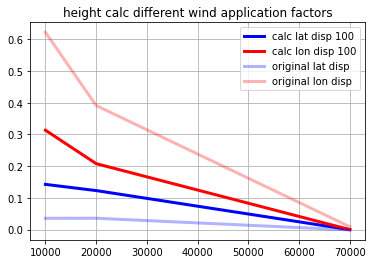

lat disp rmse:  0.0796476887495843
lon disp rmse:  0.20728093903993278


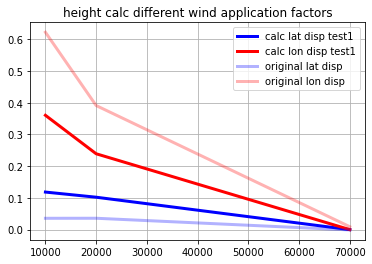

levels:  3
lat disp rmse:  0.061167376886642914
lon disp rmse:  0.17480330066209163
----------------
35.040000000000006 -106.62 19201130.0 230300.0


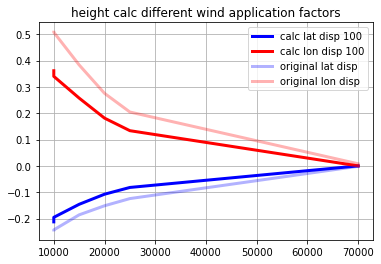

lat disp rmse:  0.03767778187379669
lon disp rmse:  0.11488808242595965


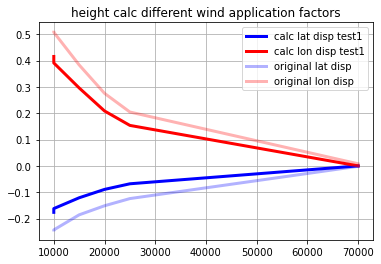

levels:  6
lat disp rmse:  0.06085776301105008
lon disp rmse:  0.0782798841542999
----------------
37.760000000000005 -99.97000000000001 19201130.0 230100.0


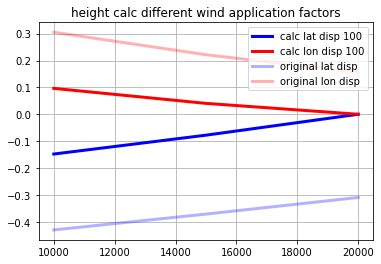

lat disp rmse:  0.29541176829248694
lon disp rmse:  0.1833872223054006


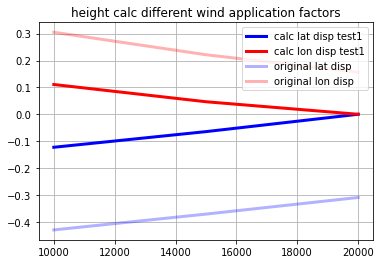

levels:  3
lat disp rmse:  0.3079967919005859
lon disp rmse:  0.17598257485041507
----------------
40.86000000000001 -115.74000000000001 19201130.0 230300.0


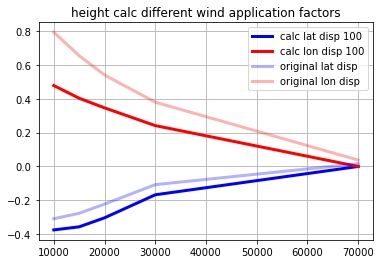

lat disp rmse:  0.06507037888454761
lon disp rmse:  0.2098964114666063


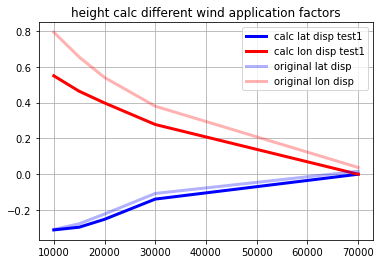

levels:  5
lat disp rmse:  0.02242254938045532
lon disp rmse:  0.15973411464856246
----------------
39.120000000000005 -108.53000000000002 19201130.0 230100.0


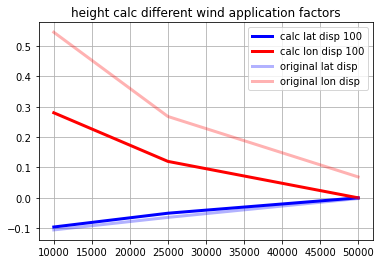

lat disp rmse:  0.009762245960080474
lon disp rmse:  0.17961297660050562


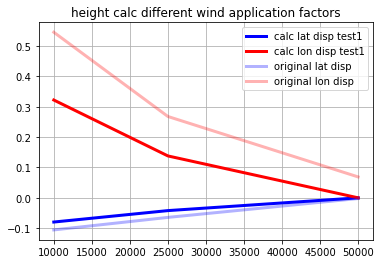

levels:  3
lat disp rmse:  0.01979512656611979
lon disp rmse:  0.15417245258224366
----------------
39.42 -83.82000000000001 19201130.0 230500.0


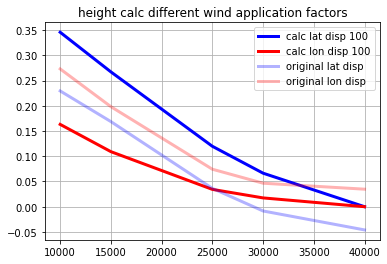

lat disp rmse:  0.08708771413888626
lon disp rmse:  0.06881426318675563


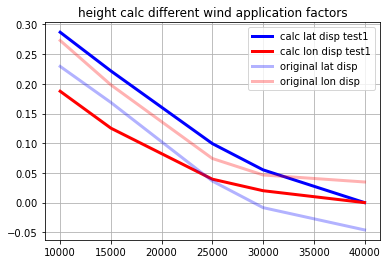

levels:  5
lat disp rmse:  0.05704201706381923
lon disp rmse:  0.05610700684997824
----------------
40.150000000000006 -89.34 19201130.0 230100.0


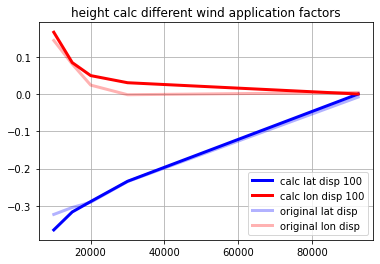

lat disp rmse:  0.019688676383003565
lon disp rmse:  0.020971622925942082


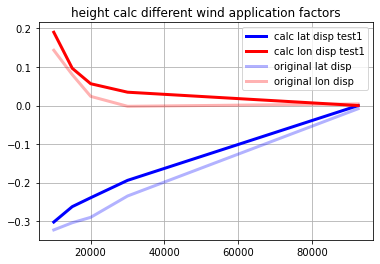

levels:  5
lat disp rmse:  0.03594595657010684
lon disp rmse:  0.03123473735724876
----------------
13.48 144.79000000000002 19201130.0 230100.0


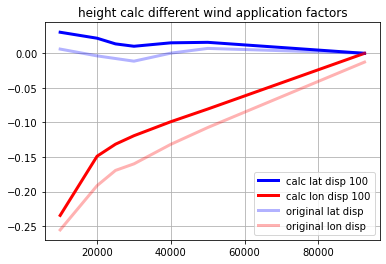

lat disp rmse:  0.018745447085291737
lon disp rmse:  0.032289589477051


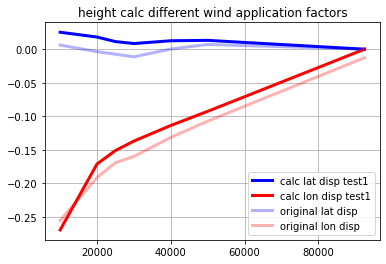

levels:  7
lat disp rmse:  0.01595712003635633
lon disp rmse:  0.017573681011336655
----------------
40.53 -80.22000000000001 19201130.0 230800.0


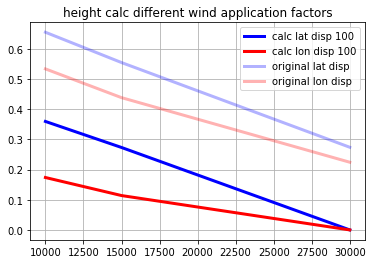

lat disp rmse:  0.28393961194797884
lon disp rmse:  0.3084740422176481


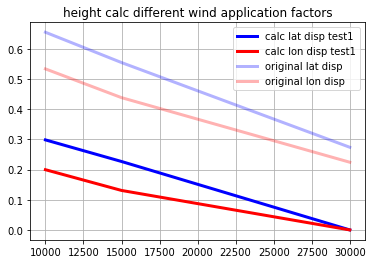

levels:  3
lat disp rmse:  0.32151721711099324
lon disp rmse:  0.29255458702023457
----------------
27.71 -82.4 19201130.0 230300.0


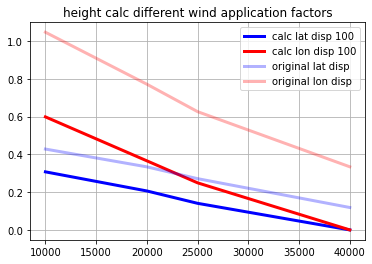

lat disp rmse:  0.12452528655196132
lon disp rmse:  0.3935714228322686


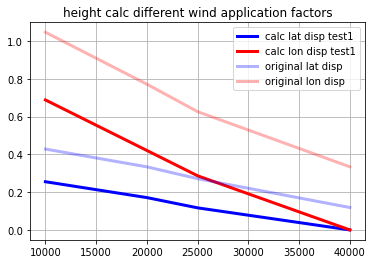

levels:  4
lat disp rmse:  0.15364034290291548
lon disp rmse:  0.346012308145991
----------------
34.84 -92.26 19201130.0 231100.0


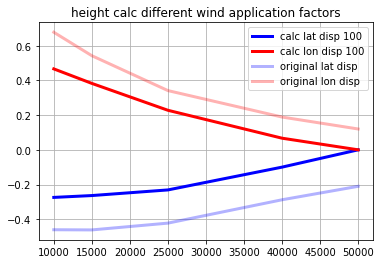

lat disp rmse:  0.19497682537785263
lon disp rmse:  0.14979492757482157


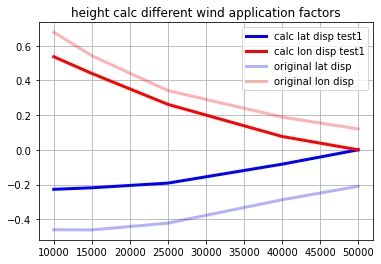

levels:  5
lat disp rmse:  0.2247793539316202
lon disp rmse:  0.11279846288334475
----------------
36.25 -86.56 19201130.0 230700.0


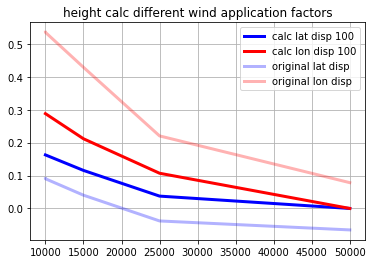

lat disp rmse:  0.07221516539042602
lon disp rmse:  0.1939967669429978


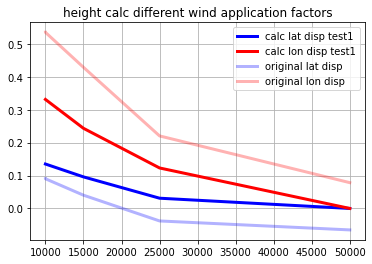

levels:  5
lat disp rmse:  0.05675268791770854
lon disp rmse:  0.16314887461120012
----------------
35.230000000000004 -101.71000000000001 19201130.0 230600.0


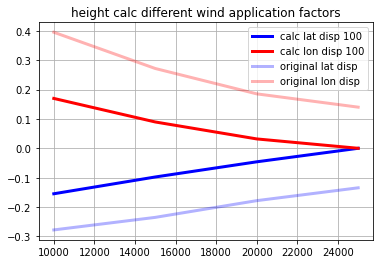

lat disp rmse:  0.13192678508729422
lon disp rmse:  0.178210897200847


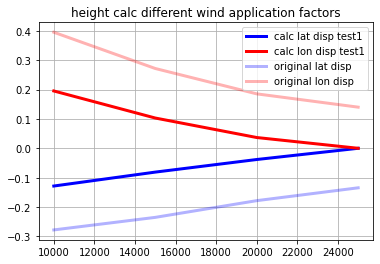

levels:  4
lat disp rmse:  0.14470954370678304
lon disp rmse:  0.1658797485062125
----------------
47.68000000000001 -117.63000000000001 19201130.0 230400.0


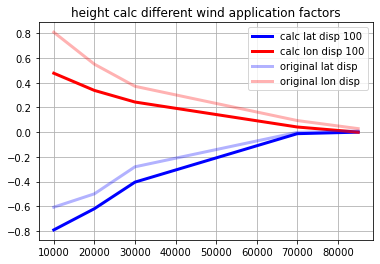

lat disp rmse:  0.11286692198626494
lon disp rmse:  0.1867727813917778


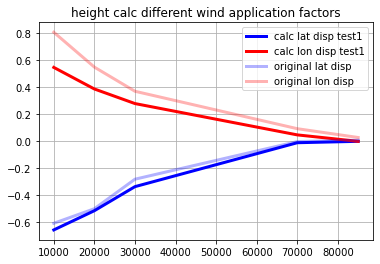

levels:  5
lat disp rmse:  0.034075957428705575
lon disp rmse:  0.14501164311953485
----------------
42.940000000000005 -78.72000000000001 19201130.0 231300.0


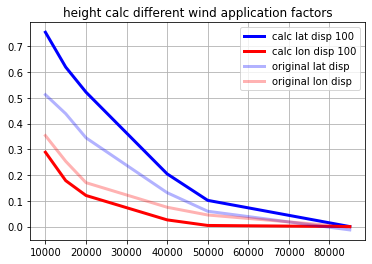

lat disp rmse:  0.14742713122308349
lon disp rmse:  0.052224195627253105


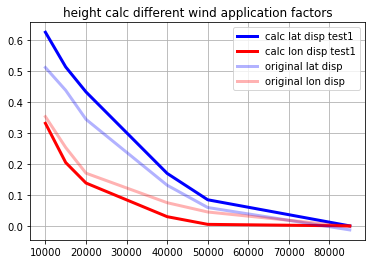

levels:  6
lat disp rmse:  0.0693580493721607
lon disp rmse:  0.035347104687325985
----------------
27.78 -97.51 19201130.0 230800.0


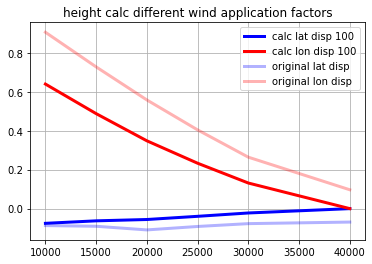

lat disp rmse:  0.04867818149679181
lon disp rmse:  0.19509336294748286


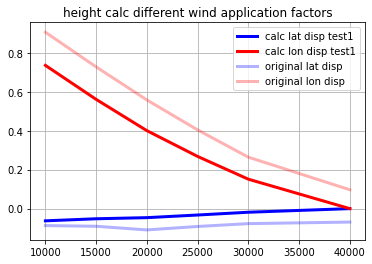

levels:  6
lat disp rmse:  0.054257236062230055
lon disp rmse:  0.1426709769062656
----------------
31.94 -102.19000000000001 19201130.0 230300.0


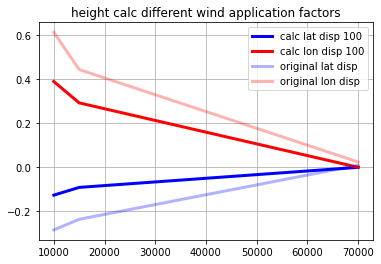

lat disp rmse:  0.12357882010281317
lon disp rmse:  0.1562827419998135


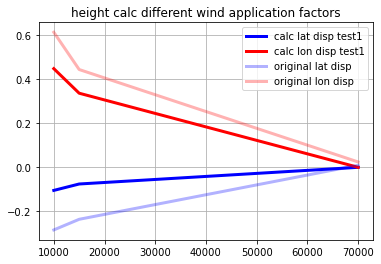

levels:  3
lat disp rmse:  0.13873303853564012
lon disp rmse:  0.11447644142071653
----------------
32.32 -90.08000000000001 19201130.0 230600.0


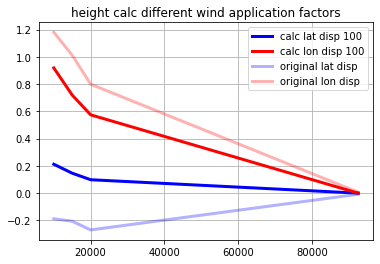

lat disp rmse:  0.32377307866282906
lon disp rmse:  0.22610835082910488


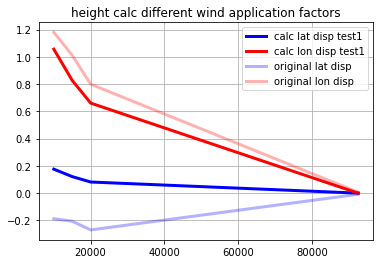

levels:  4
lat disp rmse:  0.30116859954207115
lon disp rmse:  0.13104321958483334
----------------
44.85 -93.56 19201130.0 230300.0


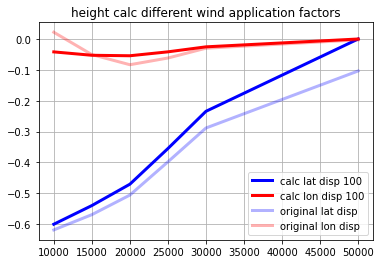

lat disp rmse:  0.05475247122145827
lon disp rmse:  0.029828951756146412


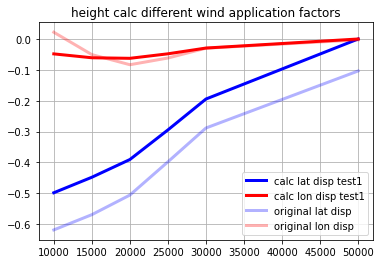

levels:  6
lat disp rmse:  0.11016005535716274
lon disp rmse:  0.030697813041001835
----------------
19.720000000000002 -155.06 19201130.0 230300.0


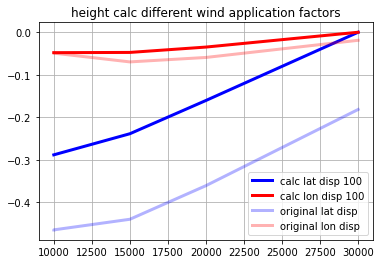

lat disp rmse:  0.18762734602429385
lon disp rmse:  0.017058352296940343


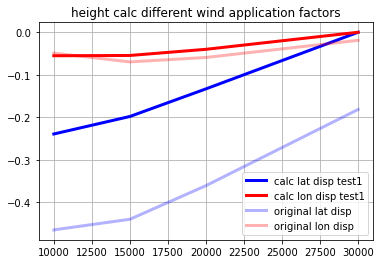

levels:  5
lat disp rmse:  0.22141241975778805
lon disp rmse:  0.014353361601498311
----------------
32.900000000000006 -80.03 19201130.0 230600.0


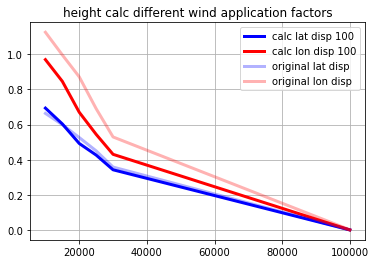

lat disp rmse:  0.021956826703345613
lon disp rmse:  0.1407097482605043


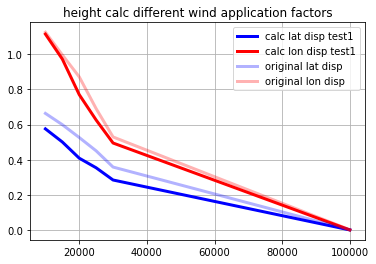

levels:  6
lat disp rmse:  0.08767249762291078
lon disp rmse:  0.05219128101036189
----------------
44.07 -103.21000000000001 19201130.0 230600.0


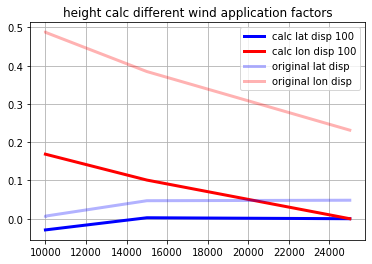

lat disp rmse:  0.041605963335292886
lon disp rmse:  0.2903594222998221


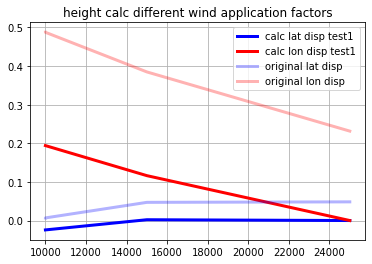

levels:  4
lat disp rmse:  0.03966728400829355
lon disp rmse:  0.2728913957481987
----------------
41.32 -96.37 19201130.0 231100.0


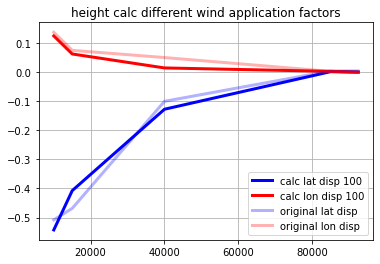

lat disp rmse:  0.0336345837030242
lon disp rmse:  0.017843099161263275


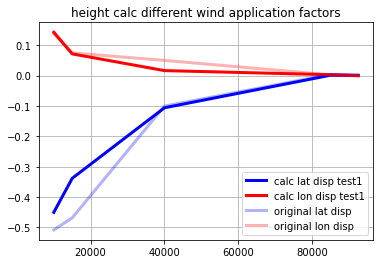

levels:  5
lat disp rmse:  0.06382146945035427
lon disp rmse:  0.015326821536049934
----------------
-14.340000000000002 -170.72000000000003 19201130.0 230100.0


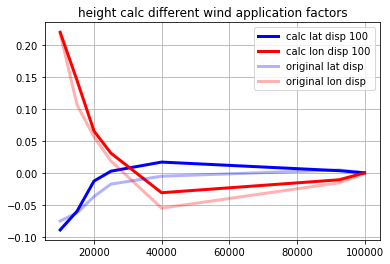

lat disp rmse:  0.015503192495188115
lon disp rmse:  0.01808951776283663


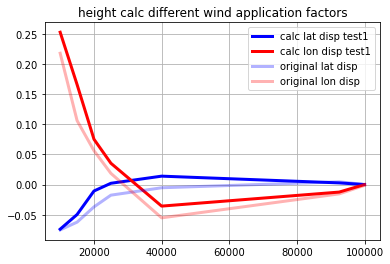

levels:  7
lat disp rmse:  0.015210007607923254
lon disp rmse:  0.028806909793121057
----------------
40.77 -111.96000000000001 19201130.0 230600.0


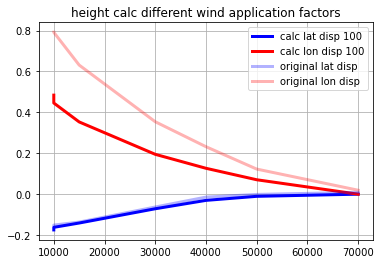

lat disp rmse:  0.013101519056781688
lon disp rmse:  0.21742457723331857


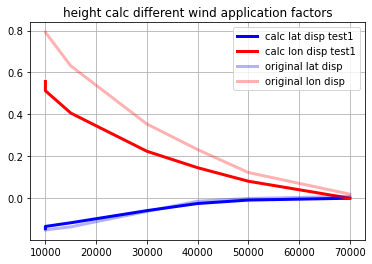

levels:  7
lat disp rmse:  0.01170135815983502
lon disp rmse:  0.17321626348205738
----------------
33.36 -84.57000000000001 19201130.0 231000.0


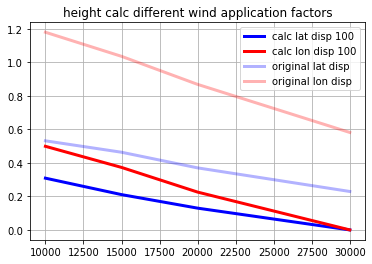

lat disp rmse:  0.2367474514555136
lon disp rmse:  0.6434211114547175


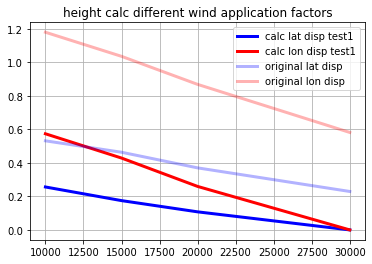

levels:  4
lat disp rmse:  0.26503618597460554
lon disp rmse:  0.6012866767940395
----------------
48.21 -106.63000000000001 19201130.0 230100.0


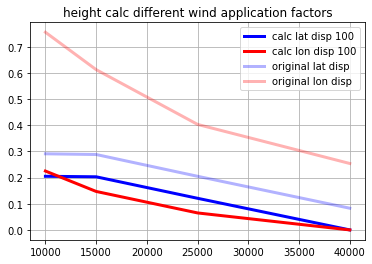

lat disp rmse:  0.08452016992587717
lon disp rmse:  0.41121868157565794


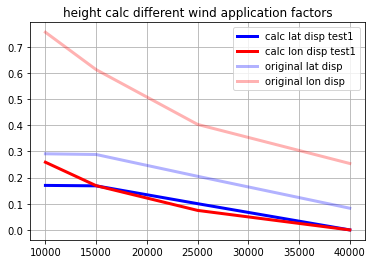

levels:  4
lat disp rmse:  0.1080745500898434
lon disp rmse:  0.39222052584738437
----------------
46.77 -100.76 19201130.0 230800.0


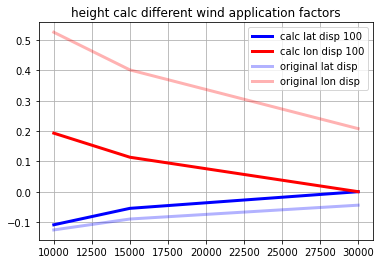

lat disp rmse:  0.034172801362150014
lon disp rmse:  0.2809722189756383


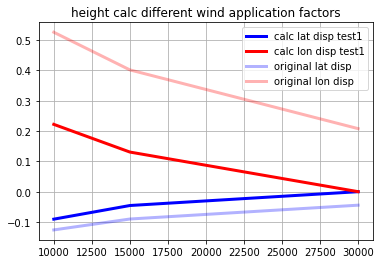

levels:  3
lat disp rmse:  0.041716071121061946
lon disp rmse:  0.26387695964527474
----------------
32.230000000000004 -110.96000000000001 19201130.0 230300.0


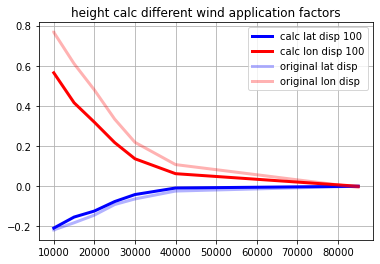

lat disp rmse:  0.016965315285790677
lon disp rmse:  0.14466070474232376


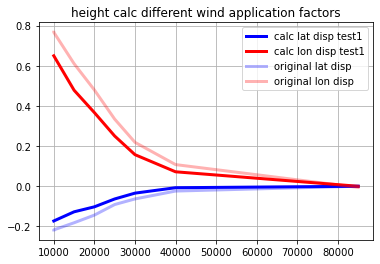

levels:  8
lat disp rmse:  0.03623154046406475
lon disp rmse:  0.09335751265976128
----------------
35.230000000000004 -111.82000000000001 19201130.0 231900.0


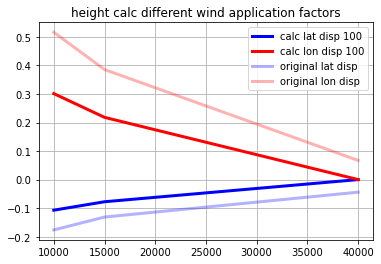

lat disp rmse:  0.0565638441116495
lon disp rmse:  0.1620272440545761


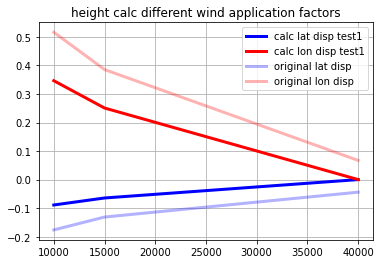

levels:  3
lat disp rmse:  0.06841914691259898
lon disp rmse:  0.13101090282246491
----------------
32.84 -97.30000000000001 19201130.0 230900.0


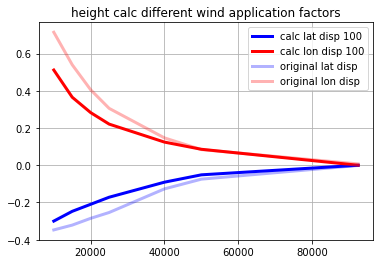

lat disp rmse:  0.05602770461011244
lon disp rmse:  0.11603572066838423


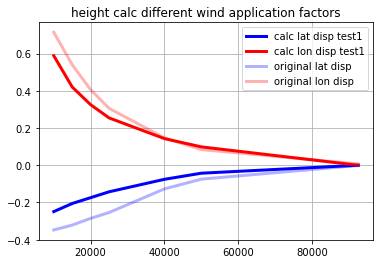

levels:  7
lat disp rmse:  0.08581677914375524
lon disp rmse:  0.07516716402656427
----------------
[0.0796476887495843, 0.03767778187379669, 0.29541176829248694, 0.06507037888454761, 0.009762245960080474, 0.08708771413888626, 0.019688676383003565, 0.018745447085291737, 0.28393961194797884, 0.12452528655196132, 0.19497682537785263, 0.07221516539042602, 0.13192678508729422, 0.11286692198626494, 0.14742713122308349, 0.04867818149679181, 0.12357882010281317, 0.32377307866282906, 0.05475247122145827, 0.18762734602429385, 0.021956826703345613, 0.041605963335292886, 0.0336345837030242, 0.015503192495188115, 0.013101519056781688, 0.2367474514555136, 0.08452016992587717, 0.034172801362150014, 0.016965315285790677, 0.0565638441116495, 0.05602770461011244]
data set 0:  0.06507037888454761 0.178210897200847
data set 1:  0.06382146945035427 0.13104321958483334
data set 2:  nan nan


/users/staff/a1400070/.conda/envs/uv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/users/staff/a1400070/.conda/envs/uv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [112]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()

# Testing

In [6]:
# def par_read_bufr_stn_nofeedback(varno,bufrfile):
#     old_rmse = 1
#     older_rmse = 1
#     fff = 1.0
#     while True:
#         alldata=''
#         alldict=dict()

#         bufrlist=[]
#         tx=time.time()
#     #     try:
#         f = open(bufrfile)
#         print(f)
#         cnt = 0
#         output = {}
#         # loop over the messages in the file
#         bc = 0


#         rmse_sum_lat = []
#         rmse_sum_lon = []
#         rmse_sum_lat_1 = []
#         rmse_sum_lon_1 = []
#         rmse_sum_lat_2 = []
#         rmse_sum_lon_2 = []

#         while 1:
#     #         try:
#             # get handle for message
#             bufr = codes_bufr_new_from_file(f)
#             if bufr is None:
#                 break
#             # we need to instruct ecCodes to expand all the descriptors
#             # i.e. unpack the data section
#             if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#                 codes_release(bufr)
#                 continue
#             codes_set(bufr, 'unpack', 1)
#             # get all the timePeriods
#             iterid = codes_bufr_keys_iterator_new(bufr)

#             # loop over the keys
#             #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#                 ##print (codes_get_array(bufr,'dataSubCategory')[0])
#                 #codes_release(bufr)
#                 #continue
#             hires=False
#             while codes_bufr_keys_iterator_next(iterid):

#                 # print key name
#                 keyname = codes_bufr_keys_iterator_get_name(iterid)
#     #             print(keyname,codes_get_array(bufr,keyname))
#                 #if keyname in ['#1#blockNumber','#1#stationNumber']:
#                     #print (keyname,codes_get_array(bufr,keyname))
#                 if 'latitudeDisplacement' in keyname:
#                     hires=True
#             if not hires:
#                 codes_bufr_keys_iterator_delete(iterid)
#                 continue
#             ## delete the key iterator
#             codes_bufr_keys_iterator_delete(iterid)
#             output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
#             output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
#             output['pressure'] = codes_get_array(bufr, "pressure")
#             output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
#             output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
#             output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
#             output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
#             output['airTemperature'] = codes_get_array(bufr, "airTemperature")
#             dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
#             output['windDirection'] = codes_get_array(bufr, "windDirection")
#             output['windSpeed'] = codes_get_array(bufr, "windSpeed")
#             output['lat'] = codes_get(bufr, "latitude")
#             output['lon'] = codes_get(bufr, "longitude")
#             output['alt'] = float(codes_get(bufr, "heightOfStation"))
#             output['blockNumber'] = codes_get(bufr, "blockNumber")
#             output['stationNumber'] = codes_get(bufr, "stationNumber")
#             try:
#                 data = pd.DataFrame.from_dict(output)
#                 cont = True
#             except:
#                 cont = False
#             if cont:
#                 if data.pressure[0] < 40000:
#                     u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
#                     data['u'] = u
#                     v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
#                     data['v'] = v
#                     data = data[data.airTemperature < 350]
#                     data = data[data.airTemperature > 180]

#                     true_latd = data.latitudeDisplacement
#                     true_lond = data.longitudeDisplacement


#                     lat_displacement_100, lon_displacement_100 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), u_factor=0.83, v_factor = fff)

#                     rmse_sum_lat.append(np.sqrt(np.nanmean((np.array(lat_displacement_100)-true_latd)**2)))
#                     rmse_sum_lon.append(np.sqrt(np.nanmean((np.array(lon_displacement_100)-true_lond)**2)))

#                     bc += 1
#     #         except:
#     #             pass
#             if bc > 100: #if bc > 30:
#                 break
#         print(fff)
#         print('data set 0: ',np.median(rmse_sum_lat), np.median(rmse_sum_lon))
#         if (old_rmse < np.median(rmse_sum_lon)) and (older_rmse < np.median(rmse_sum_lon)):
#             break
#         else:
#             older_rmse = old_rmse
#             old_rmse = np.median(rmse_sum_lon)
#             fff += 0.01
        
#     return output #, true_sum_lon, true_sum_lat, rmse_sum_lon, rmse_sum_lat, rmse_sum_lon_1, rmse_sum_lat_1, rmse_sum_lon_2, rmse_sum_lat_2


In [8]:
# ipath=os.path.expanduser('~leo/ectrans/')
# sodblist=glob.glob(ipath+'era5.bufr.202012')
# sodblist.sort(key=os.path.getsize)
# out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# # #list(map(func,  idx2))
# # func = partial(par_read_bufr_stn_nofeedback,111)
# # list(map(func,sodblist))

# # # exit()

In [ ]:
# 0.83
# data set 0:  0.00991811611498853 0.07403057705528218

# 1.15
# data set 0:  0.009949274964413392 0.03332059666137682

In [9]:
# ipath=os.path.expanduser('~leo/ectrans/')
# sodblist=glob.glob(ipath+'era5.bufr.202012')
# sodblist.sort(key=os.path.getsize)
# out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# # #list(map(func,  idx2))
# # func = partial(par_read_bufr_stn_nofeedback,111)
# # list(map(func,sodblist))

# # # exit()

In [ ]:
# 0.0.89 best

In [10]:
# np.median([0.004026060226545581, 0.015053064387238493, 0.05587934027409499, 0.0520707707544202, 0.006163682844790717, 0.03652986677471854, 0.05371066565696349, 0.002135700881775383, 0.04561160537375737, 0.024049554001244654, 0.07831132571573378, 0.015688430982708598, 0.02046324145616523, 0.11427689817128714, 0.1521692843032471, 0.012524569439422852, 0.008844739563659606, 0.011973774497239588, 0.06666337796043946, 0.013092051431928172, 0.047546943773941204, 0.004694401622177236, 3.4994683532037295e+99, 0.0026279925812808594, 0.009162964185459178, 182.8680655532829, 0.030742933745597254, 0.01871743408464339, 0.010280879518333853, 0.024010832109441927, 0.006760302071858719])

# Height testing

In [80]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    while 1:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
            ##print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

            # print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#             print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        return output


In [81]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()


<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202012' mode='r' encoding='UTF-8'>


In [82]:
data = pd.DataFrame.from_dict(out)
u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
data['u'] = u
v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
data['v'] = v
data = data[data.airTemperature < 350]
data = data[data.airTemperature > 180]
reduced = data[numpy.isin(data.pressure, [100000,85000,75000,50000,40000,30000,20000,10000,5000,3000,1000])]
data


,datum,timePeriod,pressure,extendedVerticalSoundingSignificance,geopotentialHeight,latitudeDisplacement,longitudeDisplacement,airTemperature,windDirection,windSpeed,lat,lon,alt,blockNumber,stationNumber,u,v
0,19201130.0,213100.0,101130.0,145408,7,0.00000,0.00000,285.85,178,8.7,-40.9,174.98,8.0,93,417,-8.694700,0.303626
1,19201130.0,213100.0,101050.0,0,14,0.00025,-0.00017,285.64,175,7.3,-40.9,174.98,8.0,93,417,-7.272221,0.636237
2,19201130.0,213100.0,101040.0,0,15,0.00036,-0.00025,285.52,173,6.8,-40.9,174.98,8.0,93,417,-6.749314,0.828712
3,19201130.0,213100.0,101010.0,0,17,0.00043,-0.00030,285.52,172,6.6,-40.9,174.98,8.0,93,417,-6.535769,0.918542
4,19201130.0,213100.0,100940.0,0,23,0.00048,-0.00033,285.46,172,6.6,-40.9,174.98,8.0,93,417,-6.535769,0.918542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3639,19201130.0,213100.0,2230.0,0,25991,0.33203,0.21890,219.65,84,12.5,-40.9,174.98,8.0,93,417,1.306606,12.431524
3640,19201130.0,213100.0,2220.0,0,26019,0.33202,0.21821,219.77,85,12.6,-40.9,174.98,8.0,93,417,1.098162,12.552053
3641,19201130.0,213100.0,2210.0,0,26048,0.33200,0.21750,219.99,86,12.7,-40.9,174.98,8.0,93,417,0.885907,12.669063
3642,19201130.0,213100.0,2200.0,0,26080,0.33198,0.21656,220.31,87,12.8,-40.9,174.98,8.0,93,417,0.669900,12.782458


---
---

In [83]:
reduced = reduced.reset_index()
reduced

,index,datum,timePeriod,pressure,extendedVerticalSoundingSignificance,geopotentialHeight,latitudeDisplacement,longitudeDisplacement,airTemperature,windDirection,windSpeed,lat,lon,alt,blockNumber,stationNumber,u,v
0,17,19201130.0,213100.0,100000.0,65536,101,0.00138,-0.00068,284.67,173,7.8,-40.9,174.98,8.0,93,417,-7.741860,0.950581
1,284,19201130.0,213100.0,85000.0,65536,1431,0.05313,-0.01483,274.17,156,25.5,-40.9,174.98,8.0,93,417,-23.295409,10.371784
2,1034,19201130.0,213100.0,50000.0,65536,5622,0.13559,-0.00736,259.41,218,25.9,-40.9,174.98,8.0,93,417,-20.409479,-15.945632
3,1291,19201130.0,213100.0,40000.0,65536,7275,0.17530,0.04091,245.79,218,20.3,-40.9,174.98,8.0,93,417,-15.996618,-12.497928
4,1621,19201130.0,213100.0,30000.0,65536,9273,0.22488,0.10682,228.56,236,28.3,-40.9,174.98,8.0,93,417,-15.825159,-23.461763
5,2035,19201130.0,213100.0,20000.0,65536,11932,0.27018,0.18797,223.15,230,15.9,-40.9,174.98,8.0,93,417,-10.220323,-12.180107
6,2862,19201130.0,213100.0,10000.0,79872,16428,0.31930,0.31122,217.35,283,4.2,-40.9,174.98,8.0,93,417,0.944794,-4.092354
7,3362,19201130.0,213100.0,5000.0,65536,20831,0.33754,0.32266,217.16,93,6.0,-40.9,174.98,8.0,93,417,-0.314016,5.991777
8,3562,19201130.0,213100.0,3000.0,65536,24097,0.33523,0.26846,218.42,87,10.9,-40.9,174.98,8.0,93,417,0.570462,10.885062


In [84]:
t = reduced.airTemperature
p = reduced.pressure
for i in range(len(reduced)):
    if i != 0:
        # from: https://www.cesm.ucar.edu/models/cesm1.1/cesm/cesmBbrowser/html_code/cam/tropopause.F90.html
        SHR_CONST_AVOGAD  = 6.02214e26
        SHR_CONST_BOLTZ   = 1.38065e-23
        SHR_CONST_MWDAIR  = 28.966
        SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
        SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR
        rair = SHR_CONST_RDAIR
        
        SHR_CONST_G       = 9.80616
        gravit = SHR_CONST_G
        
        SHR_CONST_CPDAIR  = 1.00464e3
        cappa        = (SHR_CONST_RGAS/SHR_CONST_MWDAIR)/SHR_CONST_CPDAIR
        cnst_kap = cappa

        cnst_faktor = -gravit/rair
        cnst_ka1    = cnst_kap - 1.

        # dt/dz
        pmk= .5 * (p[i-1]**cnst_kap+p[i]**cnst_kap)
        pm = pmk**(1/cnst_kap)               
        a = (t[i-1]-t[i])/(p[i-1]**cnst_kap-p[i]**cnst_kap)
        b = t[i]-(a*p[i]**cnst_kap)
        tm = a * pmk + b               
        dtdp = a * cnst_kap * (pm**cnst_ka1)
        dtdz = cnst_faktor*dtdp*pm/tm
        print(dtdz)
        print((reduced.airTemperature[i-1]-reduced.airTemperature[i])/(np.log(reduced.pressure[i-1] - reduced.pressure[i])))
        print((reduced.airTemperature[i]-reduced.airTemperature[i-1])/(reduced.geopotentialHeight[i] - reduced.geopotentialHeight[i-1]))
        print('---')
 # /1000? K/m -> K/km

-0.007900579329182922
1.3664103247344474e-08
2137.9980563654035
1.0919522053297501
64.60785849653128
-0.007894736842105263
---
-0.003568701747732631
5.278847203045903e-08
651.8286757211599
1.4106713390574988
27.816083991861674
-0.003521832498210449
---
-0.008257708587099158
7.20325162320732e-08
2472.3545805987533
1.4787727108805762
61.036942003408285
-0.00823956442831218
---
-0.008631793486138798
1.5102046424785095e-07
1954.351096213298
1.8707234807982562
59.892505129557605
-0.008623623623623618
---
-0.0020204702460686983
1.0486310720251808e-07
6224.301180731076
0.5873832867741478
13.34270173145645
-0.0020345994734862717
---
-0.0013021346598649196
4.502436827888656e-07
5805.770584095696
0.6297269987597165
8.367631237156003
-0.0012900355871886147
---
-4.3244177689411905e-05
6.174709720736007e-08
354457.5725026895
0.02230781851836856
0.27411205776889974
-4.315239609357205e-05
---
0.0003875992910458135
-1.188941166760665e-06
-133624.87852283564
-0.1657697894041819
-2.466595138103773
0.000

In [85]:
ucar = []
bufr = []
t = data.airTemperature
p = data.pressure
for i in range(len(data)):
    if i != 0:
        # from: https://www.cesm.ucar.edu/models/cesm1.1/cesm/cesmBbrowser/html_code/cam/tropopause.F90.html
        SHR_CONST_AVOGAD  = 6.02214e26
        SHR_CONST_BOLTZ   = 1.38065e-23
        SHR_CONST_MWDAIR  = 28.966
        SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
        SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR
        rair = SHR_CONST_RDAIR
        
        SHR_CONST_G       = 9.80616
        gravit = SHR_CONST_G
        
        SHR_CONST_CPDAIR  = 1.00464e3
        cappa        = (SHR_CONST_RGAS/SHR_CONST_MWDAIR)/SHR_CONST_CPDAIR
        cnst_kap = cappa

        cnst_faktor = -gravit/rair
        cnst_ka1    = cnst_kap - 1.

        # dt/dz
        pmk= .5 * (p[i-1]**cnst_kap+p[i]**cnst_kap)
        pm = pmk**(1/cnst_kap)               
        a = (t[i-1]-t[i])/(p[i-1]**cnst_kap-p[i]**cnst_kap)
        b = t[i]-(a*p[i]**cnst_kap)
        tm = a * pmk + b               
        dtdp = a * cnst_kap * (pm**cnst_ka1)
        dtdz = cnst_faktor*dtdp*pm/tm
        ucar.append(dtdz)
        bufr.append(((data.airTemperature[i]-data.airTemperature[i-1])/(data.geopotentialHeight[i] - data.geopotentialHeight[i-1])))


/tmp/ipykernel_779345/29811965.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  bufr.append(((data.airTemperature[i]-data.airTemperature[i-1])/(data.geopotentialHeight[i] - data.geopotentialHeight[i-1])))


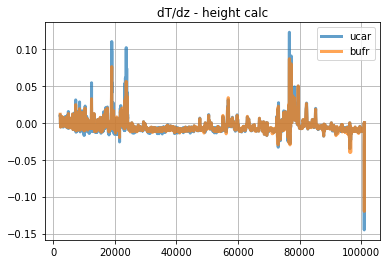

In [86]:
plt.plot(data.pressure,np.array([0]+ucar),label='ucar', alpha = 0.7)
plt.plot(data.pressure,np.array([0]+bufr),label='bufr', alpha = 0.7)
plt.title('dT/dz - height calc')
plt.legend()
plt.grid()
plt.show()

In [87]:
calc_height(np.array(data.airTemperature), np.array(data.pressure), 'pthf')[-1]

25838.04775639999

In [88]:
data = data.reset_index()

/tmp/ipykernel_779345/252234029.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  height = t[0]/L * ((p[i]/p[i-1])**(-L*287.053/9.80665) -1)
/tmp/ipykernel_779345/252234029.py:60: RuntimeWarning: invalid value encountered in double_scalars
  height = t[0]/L * ((p[i]/p[i-1])**(-L*287.053/9.80665) -1)


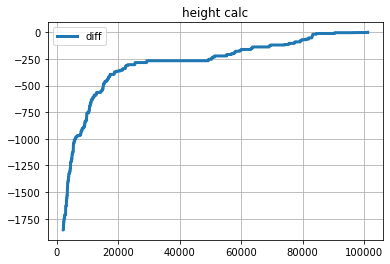

In [117]:
z= calc_height(data.airTemperature, data.pressure, variant='pthf', jump=False)
z2= calc_height(data.airTemperature, data.pressure, variant='pthf', jump=True)
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

# plt.plot(data.pressure,z,label='z')
# plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure,np.array(z)-np.array(z2),label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [118]:
z

[0,
 6.619144313586496,
 7.447217785676694,
 7.447217785676694,
 13.247086609906255,
 19.88031882545002,
 25.68871420813555,
 31.501144825651618,
 37.3178202333874,
 43.138440276532265,
 49.79553971048502,
 55.624850015332214,
 61.45822465384802,
 67.29566929761319,
 73.13718963008638,
 78.98289397477488,
 85.66846922208494,
 91.52293883948829,
 93.19648533783649,
 100.73106030151578,
 108.27229422538235,
 114.98144242274921,
 123.37574564931928,
 130.93729429864706,
 137.66453128981948,
 144.39706336457877,
 151.97737668771418,
 158.7215598388724,
 166.31500242809705,
 174.75995441344497,
 182.36837676365377,
 190.83000396589986,
 199.30004850872254,
 206.93042722178762,
 214.5680409189832,
 220.51333610088508,
 227.31313635178853,
 233.26749836397084,
 240.92906814903264,
 247.74536786133427,
 254.5675869716887,
 262.2488315767679,
 269.0824091608232,
 275.92169378130694,
 281.91065751092043,
 287.9040173593209,
 293.9016736083216,
 299.90363242231626,
 305.909899978973,
 311.0615634

In [90]:
data2 = data[np.array(z) > 20000000]

In [91]:
data2

,index,datum,timePeriod,pressure,extendedVerticalSoundingSignificance,geopotentialHeight,latitudeDisplacement,longitudeDisplacement,airTemperature,windDirection,windSpeed,lat,lon,alt,blockNumber,stationNumber,u,v


In [92]:
data[data.geopotentialHeight < 18479]

,index,datum,timePeriod,pressure,extendedVerticalSoundingSignificance,geopotentialHeight,latitudeDisplacement,longitudeDisplacement,airTemperature,windDirection,windSpeed,lat,lon,alt,blockNumber,stationNumber,u,v
0,0,19201130.0,213100.0,101130.0,145408,7,0.00000,0.00000,285.85,178,8.7,-40.9,174.98,8.0,93,417,-8.694700,0.303626
1,1,19201130.0,213100.0,101050.0,0,14,0.00025,-0.00017,285.64,175,7.3,-40.9,174.98,8.0,93,417,-7.272221,0.636237
2,2,19201130.0,213100.0,101040.0,0,15,0.00036,-0.00025,285.52,173,6.8,-40.9,174.98,8.0,93,417,-6.749314,0.828712
3,3,19201130.0,213100.0,101010.0,0,17,0.00043,-0.00030,285.52,172,6.6,-40.9,174.98,8.0,93,417,-6.535769,0.918542
4,4,19201130.0,213100.0,100940.0,0,23,0.00048,-0.00033,285.46,172,6.6,-40.9,174.98,8.0,93,417,-6.535769,0.918542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134,3134,19201130.0,213100.0,7280.0,0,18439,0.33395,0.32994,215.36,245,2.7,-40.9,174.98,8.0,93,417,-1.141069,-2.447031
3135,3135,19201130.0,213100.0,7270.0,0,18445,0.33396,0.32999,215.44,244,2.8,-40.9,174.98,8.0,93,417,-1.227439,-2.516623
3136,3136,19201130.0,213100.0,7260.0,0,18456,0.33397,0.33011,215.66,242,2.8,-40.9,174.98,8.0,93,417,-1.314520,-2.472253
3137,3137,19201130.0,213100.0,7250.0,0,18462,0.33398,0.33016,215.79,240,2.9,-40.9,174.98,8.0,93,417,-1.450000,-2.511474


In [93]:
data2 = data2.reset_index()

In [94]:
for i in range(len(data2)):
    if i != 0:
        print((np.log(data2.pressure[i-1] - data2.pressure[i])))
        print((np.log(data2.pressure[i-1]) - np.log(data2.pressure[i])))
        print((np.log(data2.pressure[i]) - np.log(data2.pressure[i-1])))

        print((data2.geopotentialHeight[i-1] - data2.geopotentialHeight[i]))
        print('---')
 # /1000? K/m -> K/km

In [95]:
z[-16]

23669.543598490705

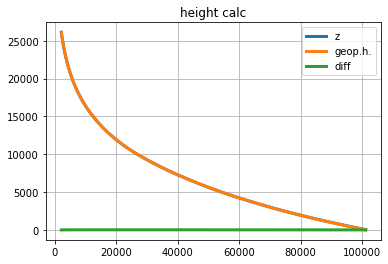

In [137]:
z = calc_height(data.airTemperature, data.pressure, jump = False)
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(data.pressure,z,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure,data.geopotentialHeight-z,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [104]:
from scipy.signal import savgol_filter
z_smooth = savgol_filter(z, 3643, 3)

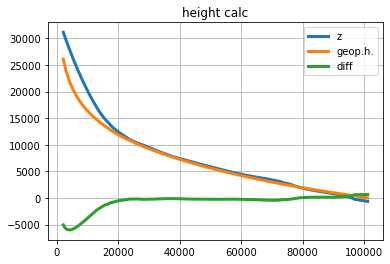

In [106]:
# z = calc_height(data.airTemperature, data.pressure, 'pthf', jump = False)
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(data.pressure,z_smooth,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure,data.geopotentialHeight-z_smooth,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [98]:
import scipy.signal

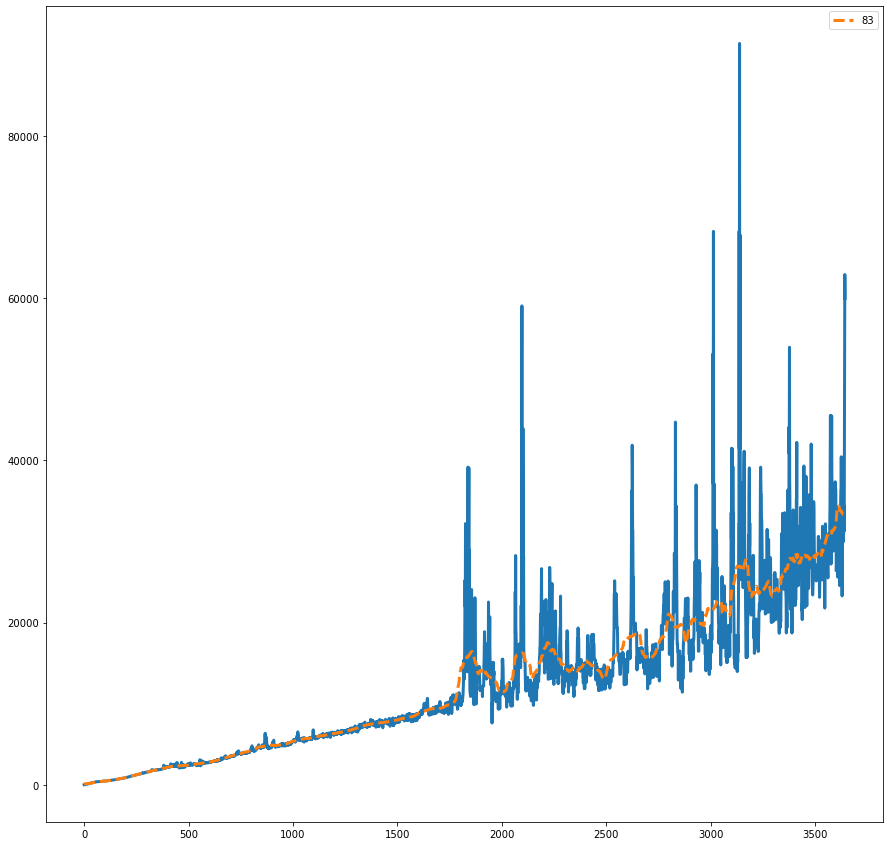

In [99]:
from scipy.ndimage.filters import uniform_filter1d

plt.figure(figsize=(15,15))
plt.plot(z)
for i in [83]:#range(3, 100, 10):
    y = uniform_filter1d(z, size=i)
    plt.plot(y, '--', label=f"{i}")

plt.legend()

In [100]:
len(z)

3644

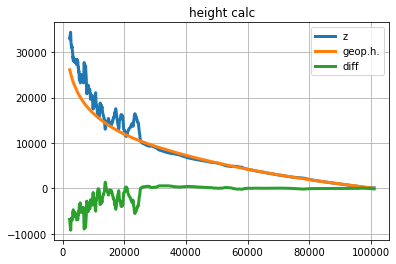

In [101]:
# z = calc_height(data.airTemperature, data.pressure, 'pthf', jump = False)
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(data.pressure,y,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure,data.geopotentialHeight-y,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

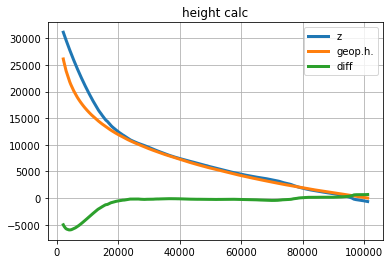

In [103]:
# z = calc_height(data.airTemperature, data.pressure, 'pthf', jump = False)
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(data.pressure,z_smooth,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure,data.geopotentialHeight-z_smooth,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

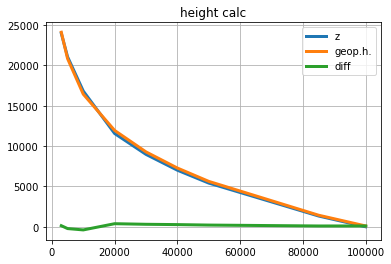

In [23]:
z = calc_height(np.array(reduced.airTemperature), np.array(reduced.pressure), 'pthf')
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(reduced.pressure,z,label='z')
plt.plot(reduced.pressure,reduced.geopotentialHeight,label='geop.h.')
plt.plot(reduced.pressure,reduced.geopotentialHeight-z,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

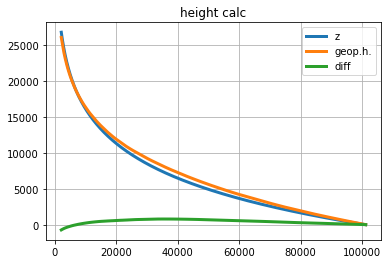

In [24]:
z = calc_height(data.airTemperature, data.pressure, 'ithf')
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(data.pressure,z,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure,data.geopotentialHeight-z,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

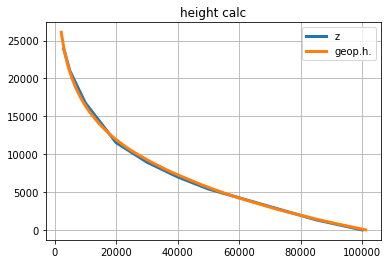

In [25]:
reduced = data[numpy.isin(data.pressure, [100000,85000,75000,50000,40000,30000,20000,10000,5000,3000,1000])]
z = calc_height(np.array(reduced.airTemperature), np.array(reduced.pressure))
vec_expint = numpy.vectorize(expint)
z = vec_expint(z)

plt.plot(reduced.pressure,z,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

---
---

In [26]:
lat = data.lat.iloc[0]
lon = data.lon.iloc[0]
print(lat, lon)
print(transport(lat, lon, [111,-111],[0,0]))

print(transport(lat, lon, 100,0))
print(transport(lat, lon, -100,0))

print(transport(lat, lon, 0,100))
print(transport(lat, lon, 0,-100))

-40.900000000000006 174.98000000000002
(array([-40.89246784, -40.89246784]), array([176.30058825, 173.65941175]))
(-40.89388663614691, 176.16973615202468)
(-40.89388663614691, 173.79026384797538)
(-40.00067839408128, 174.98000000000002)
(-41.79932160591875, 174.98000000000002)


---
---

In [27]:
lat_displacement, lon_displacement = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature))

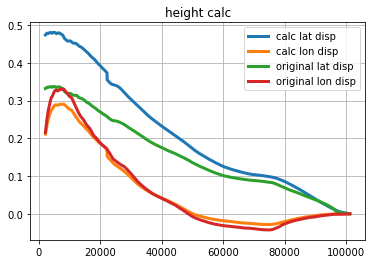

In [28]:
plt.plot(data.pressure,np.array(lat_displacement),label='calc lat disp')
plt.plot(data.pressure,np.array(lon_displacement),label='calc lon disp')
plt.plot(data.pressure,data.latitudeDisplacement,label='original lat disp')
plt.plot(data.pressure,data.longitudeDisplacement,label='original lon disp')

plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [29]:
reduced = data[numpy.isin(data.pressure, [100000,85000,75000,50000,40000,30000,20000,10000,5000,3000,1000])]
lat_displacement, lon_displacement = trajectory(np.array(reduced.lat)[0], np.array(reduced.lon)[0], np.array(reduced.u), np.array(reduced.v), np.array(reduced.pressure), np.array(reduced.airTemperature))

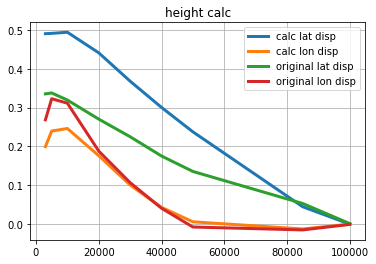

In [30]:
plt.plot(reduced.pressure,lat_displacement,label='calc lat disp')
plt.plot(reduced.pressure,lon_displacement,label='calc lon disp')
plt.plot(reduced.pressure,reduced.latitudeDisplacement,label='original lat disp')
plt.plot(reduced.pressure,reduced.longitudeDisplacement,label='original lon disp')

plt.title('height calc')
plt.legend()
plt.grid()
plt.show()